# Modelagem

In [1]:
import os
import math
import json
import shutil
import openai
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
azure_client: openai.AzureOpenAI|None = None
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata


  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


In [4]:
df = pd.concat([pd.read_parquet('./datasets/df_train_test.parquet'), pd.read_parquet('./datasets/df_validation.parquet')])
df.query('amount > 0', inplace=True)
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,Credit,5175842699412235,12/2024,438,YES,1,9100.0,09/2005,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,Debit,5874992802287595,05/2020,256,YES,1,14802.0,01/2006,2008,No
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,Debit,4354185735186651,01/2020,120,YES,1,19113.0,07/2009,2014,No
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,Debit (Prepaid),5207231566469664,03/2014,198,YES,1,89.0,01/2008,2015,No
5,7475335,2010-01-01 00:14:00,1684,2140,26.46,Online Transaction,39021,ONLINE,None,NaN,...,Debit (Prepaid),5955075527372953,05/2021,513,YES,1,46.0,03/2007,2012,No


In [5]:
df.shape

(8464991, 38)

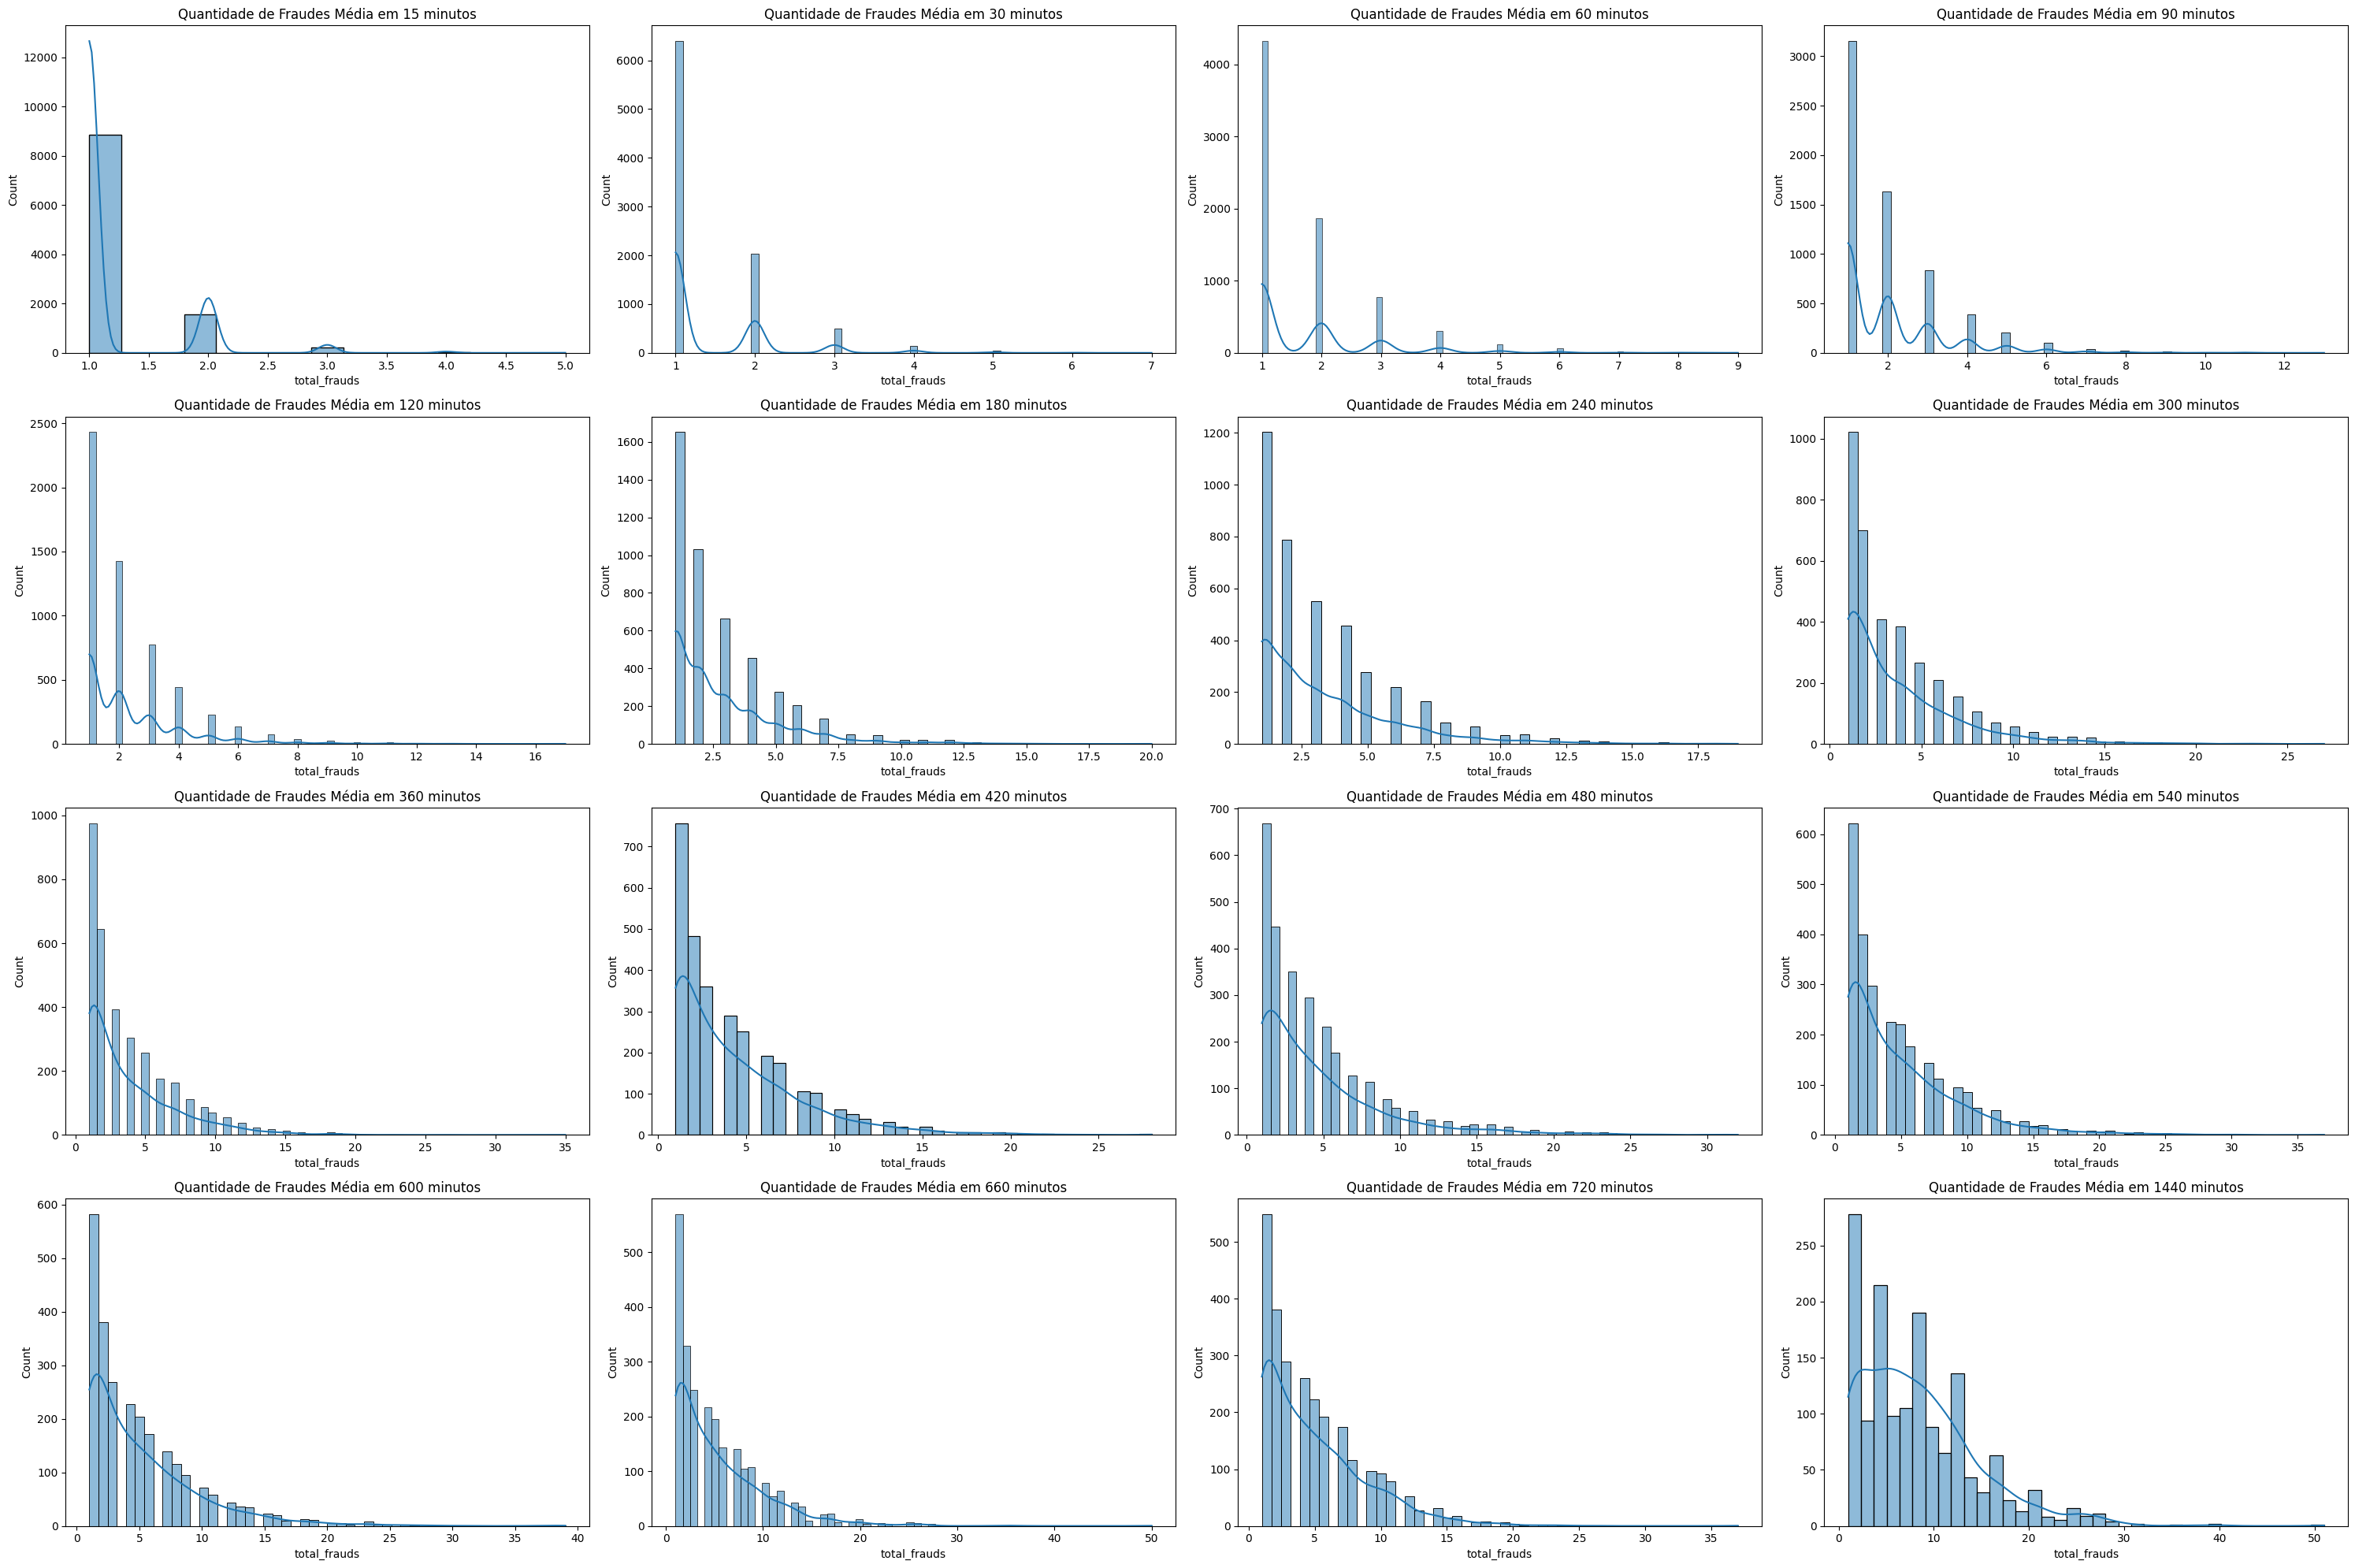

In [6]:
minutes = [15, 30, 60, 90, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 1440]

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))  # Ajuste proporcional ao número de linhas

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df['target'].apply(lambda x: 1 if x == 'Yes' else 0)

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

In [8]:
df['online_sales'] = df['merchant_city'].apply(lambda x: 'Yes' if x.lower() == 'online' else 'No')
df['city'] = df['merchant_city'].apply(lambda x: 'Online' if x.lower() == 'online' else x)
df['online_sales'] = df['merchant_state'].apply(lambda x: 'United States' if x and len(x) == 2 else x)
df['card_has_chip'] = df['has_chip'].apply(lambda x: 'Yes' if x.lower() == 'yes' else 'No')
df.drop(columns=['merchant_city', 'merchant_state', 'has_chip'])

,id,date,client_id,card_id,amount,use_chip,merchant_id,zip,mcc,errors,...,expires,cvv,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,card_has_chip
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,52722.0,5311,None,...,12/2024,438,1,9100.0,09/2005,2015,No,United States,Bettendorf,Yes
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,92084.0,4829,None,...,05/2020,256,1,14802.0,01/2006,2008,No,United States,Vista,Yes
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,20776.0,5813,None,...,01/2020,120,1,19113.0,07/2009,2014,No,United States,Harwood,Yes
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,10464.0,5942,None,...,03/2014,198,1,89.0,01/2008,2015,No,United States,Bronx,Yes
5,7475335,2010-01-01 00:14:00,1684,2140,26.46,Online Transaction,39021,NaN,4784,None,...,05/2021,513,1,46.0,03/2007,2012,No,None,Online,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509588,23761862,2019-10-31 23:54:00,672,5001,12.93,Chip Transaction,47508,37722.0,7230,None,...,01/2020,17,1,8333.0,10/2003,2007,No,United States,Cosby,Yes
1509589,23761863,2019-10-31 23:54:00,1384,3723,67.01,Chip Transaction,58136,30292.0,5812,None,...,02/2020,473,2,24617.0,07/2004,2006,No,United States,Williamson,Yes
1509590,23761869,2019-10-31 23:56:00,1766,2066,12.80,Online Transaction,39261,NaN,5815,None,...,06/2024,91,1,5141.0,03/2004,2012,No,None,Online,Yes
1509591,23761868,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,91792.0,5499,None,...,02/2020,992,1,26743.0,03/2019,2019,No,United States,West Covina,Yes


In [11]:
class DataWindow:
  def __init__(self, df: pd.DataFrame):
    self.__df = df


  def __generate_columns_statistics(self, column_name: str) -> list:
    return [
        pl.col(column_name).min().alias(f'min_{column_name}'),
        pl.col(column_name).mean().alias(f'median_{column_name}'),
        pl.col(column_name).max().alias(f'max_{column_name}'),
    ]

  def __aggregate_number_columns(self) -> list:
    aggregate = [pl.col('amount').count().alias('transactions'), pl.col('target').sum().alias('frauds'), pl.col('amount').sum().alias('total_amount')]
    for column in ['amount', 'current_age', 'per_capita_income', 'total_debt', 'credit_score', 'num_credit_cards', 'credit_limit']:
      aggregate.extend(self.__generate_columns_statistics(column))
    return aggregate

  def __create_cluster_target_fields(self, df: pl.DataFrame, group_column_name: str, target_column_name: str, n_clusters: int = 3, drop_first=False) -> pl.DataFrame:

    PERCENT_TARGET_COLUMN = f'percent_{target_column_name}'
    PERCENT_NO_TARGET_COLUMN = f'percent_no_{target_column_name}'
    AB_COLUMN = 'ab'
    TARGET_CLUSTER_COLUMN = f'{target_column_name}_{group_column_name}'

    df_cat_group = df.group_by(group_column_name).agg([
        ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(PERCENT_TARGET_COLUMN),
        (((pl.count() - pl.col(target_column_name).sum())/pl.count())*100).alias(PERCENT_NO_TARGET_COLUMN)
    ]).with_columns((pl.col(PERCENT_TARGET_COLUMN)/pl.col(PERCENT_NO_TARGET_COLUMN)).alias(AB_COLUMN)) \
      .with_columns(pl.when(pl.col(AB_COLUMN).is_infinite()).then(pl.lit(100)).otherwise(pl.col(AB_COLUMN)).alias(AB_COLUMN)) \
      .with_columns(pl.when(pl.col(AB_COLUMN) > pl.lit(100)).then(pl.lit(100)).otherwise(pl.col(AB_COLUMN)).alias(AB_COLUMN))

    min_max = MinMaxScaler()
    kmeans = KMeans(n_clusters=n_clusters)
    cluster_index = kmeans.fit_predict(min_max.fit_transform(df_cat_group[[AB_COLUMN]]))
    df_cat_group = df_cat_group.with_columns(pl.lit(cluster_index).alias(TARGET_CLUSTER_COLUMN))

    return df_cat_group.select([group_column_name, TARGET_CLUSTER_COLUMN]).to_dummies(columns=[TARGET_CLUSTER_COLUMN], drop_first=drop_first)

  def __make_previos_fraud(self, df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
      pl.when(pl.col('frauds') > pl.lit(0))
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .shift(n=1)
        .alias('previous_frauds')
        .fill_null(0)
    )
    return df

  def remove_highly_correlated_features(self, df: pd.DataFrame, threshold=0.75):
    corr_matrix = df.corr()
    upper_triangle = np.triu(np.abs(corr_matrix), k=1)

    high_corr_pairs = np.where(upper_triangle > threshold)
    columns_to_remove = set()

    for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]

        if col_i not in columns_to_remove and col_j not in columns_to_remove:
            var_i = df[col_i].var()
            var_j = df[col_j].var()

            if var_i < var_j:
                columns_to_remove.add(col_i)
            else:
                columns_to_remove.add(col_j)

    return list(columns_to_remove)

  def __make_window(self, df: pl.DataFrame, window: str) -> pl.DataFrame:
    df = df.with_columns(pl.col('date').dt.truncate(window).alias('date_window'))
    df = df.with_columns(pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target'))

    df_model = df.group_by('date_window').agg(*self.__aggregate_number_columns()).sort('date_window')

    for column in ['city', 'country', 'description']:
      df_target_cat = self.__create_cluster_target_fields(df, column, 'target', drop_first=False)
      df_with_cat = df.select(['date_window', column]).join(df_target_cat, on=column, how='left').drop(column)
      df_with_cat = df_with_cat.group_by('date_window').sum()
      df_with_cat = df_with_cat.with_columns(
          (pl.sum_horizontal([pl.col(col) for col in df_with_cat.columns[1:]])).alias('total')
      )
      df_with_cat = df_with_cat.with_columns(
          [(pl.col(col) / pl.col('total')).alias(col) for col in df_with_cat.drop('total').columns[1:]]
      ).drop('total')
      df_model = df_model.join(df_with_cat, on='date_window', how='left')
    return self.__make_previos_fraud(df_model)

  def __call__(self, window: str) -> pd.DataFrame:
     df_maked = self.__make_window(pl.from_pandas(data=self.__df), window=window).to_pandas()
     df_maked.drop(columns=self.remove_highly_correlated_features(df_maked.drop(columns=['date_window', 'transactions'])), inplace=True)
     return df_maked


In [12]:
data_window = DataWindow(df)

In [13]:
df_360 = data_window('360m')
df_360.shape

ColumnNotFoundError: country

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["id", "date", "client_id", "card_id", ...]; PROJECT */42 COLUMNS